In [50]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [51]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Set class number to train for

In [52]:
KEEP_CLASS_NUMBER = 9

### General functions

In [53]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

In [54]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [55]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

#### CNN structure

In [56]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 3
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [57]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_evaluation_report(y_true, y_pred, target_names=['Unknown (OOD)', 'Known']):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Outlier Detection Accuracy: {accuracy*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [106]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_cm(y_true, y_pred, target_names=['Unknown (OOD)', 'Known']):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Outlier Detection Accuracy: {accuracy*100:.2f}%")
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Load dataset from library

In [58]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [59]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [60]:
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'automobile', 'airplane']

In [61]:
CLASS_NUMBER = 10

## Remap labels for easier handling

In [62]:
label_mapping = {original_class_names.index(name): class_names.index(name) for name in original_class_names}

In [63]:
y_train_mapped = np.vectorize(label_mapping.get)(y_train)
y_test_mapped = np.vectorize(label_mapping.get)(y_test)

# Exclude 1 class from training
Excluded class: airplane (last in list)

# Divide into trained and unknown classes

In [64]:
keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train_mapped.flatten(), keep_classes)
test_keep_mask = np.isin(y_test_mapped.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train_mapped.flatten(), other_classes)
test_unknown_mask = np.isin(y_test_mapped.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train_mapped[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test_mapped[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train_mapped[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test_mapped[test_unknown_mask]

In [65]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({4: 5000, 7: 5000, 2: 5000, 8: 5000, 0: 5000, 5: 5000, 6: 5000, 1: 5000, 3: 5000})
Test labels and counts: Counter({1: 1000, 6: 1000, 4: 1000, 8: 1000, 7: 1000, 3: 1000, 5: 1000, 2: 1000, 0: 1000})
Unknown train labels and counts: Counter({9: 5000})
Unknown test labels and counts: Counter({9: 1000})


# Plot class distribution

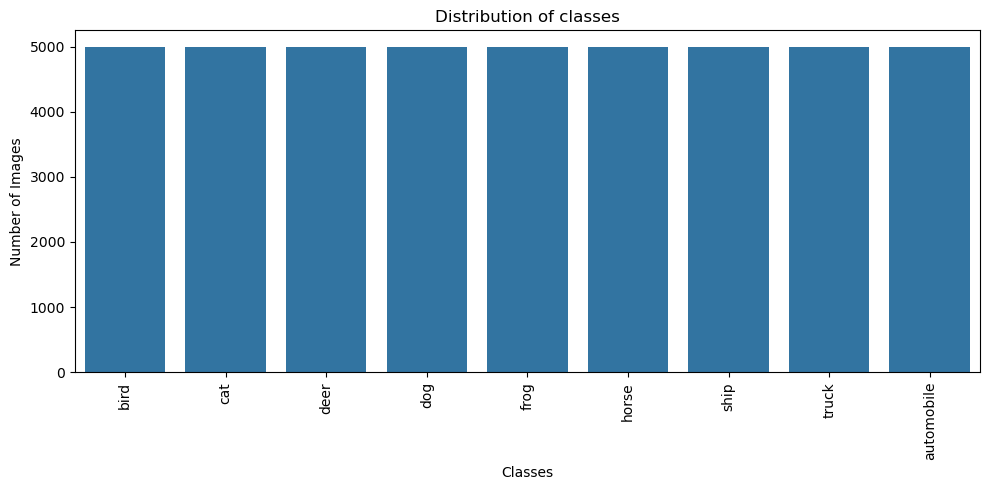

In [66]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

## Known classes

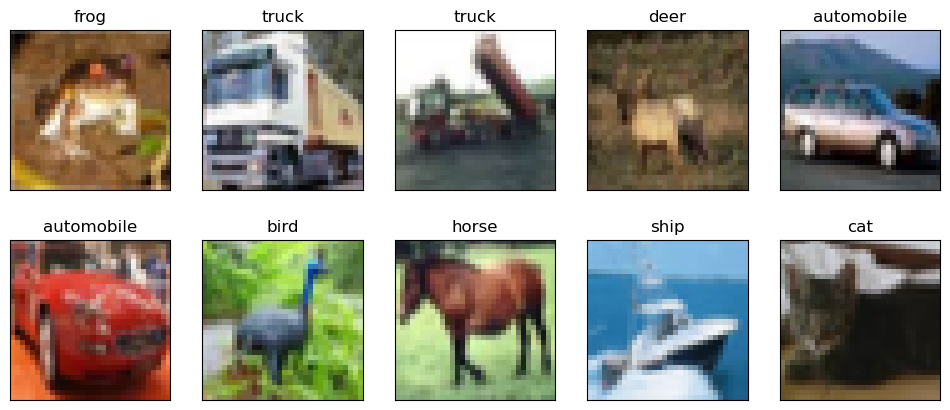

In [67]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

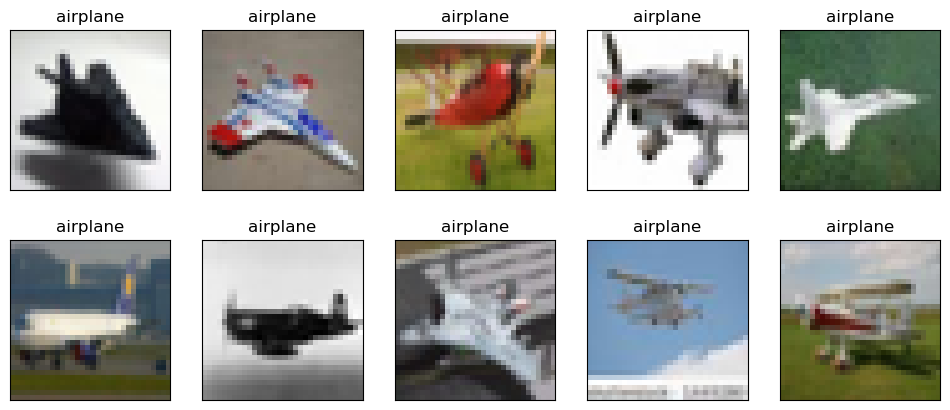

In [68]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [69]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [70]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [71]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=128,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=128,
    shuffle=False
)

# Fit simple CNN for classification

In [72]:
my_model = build_simple_cnn()

### Compile model

In [73]:
my_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Simply load saved weights

In [74]:
my_model.load_weights('models/my_model_weights_9_class_v2.keras')

### Evaluate model

In [75]:
loss, accuracy = my_model.evaluate(test_flow, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%, test loss: {loss:.4f}")

71/71 [==============================] - 2s 18ms/step - loss: 0.5538 - accuracy: 0.8147
Test accuracy: 81.47%, test loss: 0.5538


### Get intermediate logits

In [76]:
# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Extract features using different layers of the CNN classifier

## Construct datasets for outlier search

### Generate test data out of known and unknown samples

In [111]:
# Step 1: Get 2500 from unknown
X_unknown_subset_test, _, y_unknown_subset_test, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 2500), random_state=SEED, shuffle=True
)

# Step 2: Get 2500 from filtered
X_filtered_subset_test, _, y_filtered_subset_test, _ = train_test_split(
    X_test_filtered, y_test_filtered, test_size=(len(X_test_filtered) - 2500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined_test = np.concatenate([X_filtered_subset_test, X_unknown_subset_test], axis=0)
y_combined_test = np.concatenate([y_filtered_subset_test, y_unknown_subset_test], axis=0)

# Step 4: Create "known vs unknown" labels
is_known = np.concatenate([
    np.ones(len(X_filtered_subset_test)),   # known = 1
    -1 * np.ones(len(X_unknown_subset_test))  # unknown = -1
])

In [112]:
X_combined_test.shape, y_combined_test.shape

((5000, 32, 32, 3), (5000, 1))

In [113]:
subset_test_flow = test_generator.flow(X_combined_test, y_combined_test, batch_size=256, shuffle=False, seed=SEED)

## Generate artificial test data

In [114]:
artificial_N = 5000
uniform_images = np.random.uniform(low=0.0, high=1.0, size=(artificial_N, 32, 32, 3)).astype(np.float32)
normal_images = np.clip(np.random.normal(loc=0.5, scale=0.5, size=(artificial_N, 32, 32, 3)).astype(np.float32), 0.0, 1.0)
artificial_y = -1 * np.ones((artificial_N, 1), dtype=np.int32)

In [115]:
uniform_test_flow = test_generator.flow(uniform_images, artificial_y, batch_size=256, shuffle=False, seed=SEED)
normal_test_flow = test_generator.flow(normal_images, artificial_y, batch_size=256, shuffle=False, seed=SEED)

## Make predictions based off softmax outputs

In [116]:
probs = my_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 1s 31ms/step


In [117]:
max_confidence = np.max(probs, axis=1)
threshold = 0.32  # Adjusted to achieve ~95% TPR in in-distribution data

predictions = np.where(max_confidence >= threshold, 1, -1)

### Display results

Outlier Detection Accuracy: 50.72%
               precision    recall  f1-score   support

Unknown (OOD)       0.70      0.03      0.05      2500
        Known       0.50      0.99      0.67      2500

     accuracy                           0.51      5000
    macro avg       0.60      0.51      0.36      5000
 weighted avg       0.60      0.51      0.36      5000



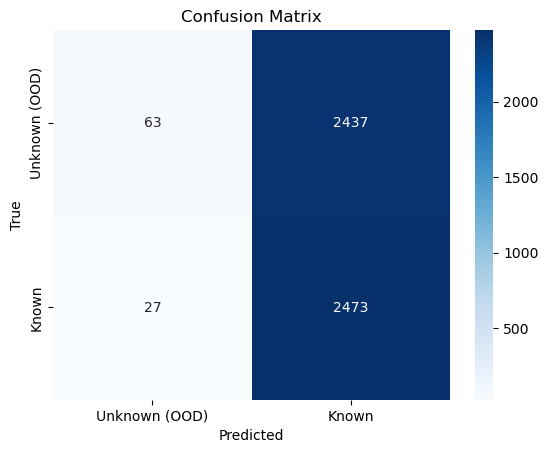

In [118]:
print_evaluation_report(is_known, predictions)

In [119]:
probs_uni = my_model.predict(uniform_test_flow, verbose=1)
probs_norm = my_model.predict(normal_test_flow, verbose=1)

20/20 [==============================] - 1s 30ms/step


In [120]:
max_confidence_uni = np.max(probs_uni, axis=1)
max_confidence_norm = np.max(probs_norm, axis=1)
threshold = 0.32

predictions_uni = np.where(max_confidence_uni >= threshold, 1, -1)
predictions_norm = np.where(max_confidence_norm >= threshold, 1, -1)

Outlier Detection Accuracy: 0.00%


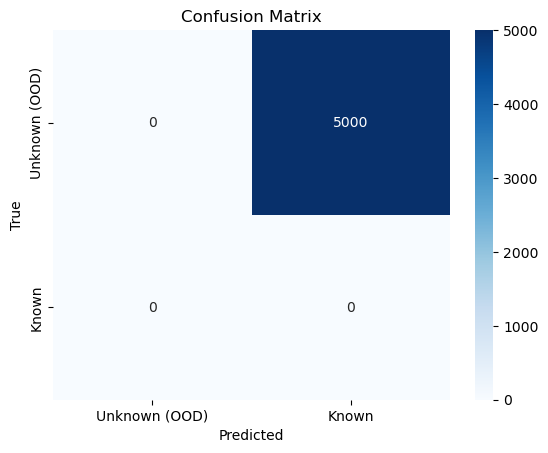

In [121]:
print_cm(artificial_y, predictions_uni)

Outlier Detection Accuracy: 0.00%


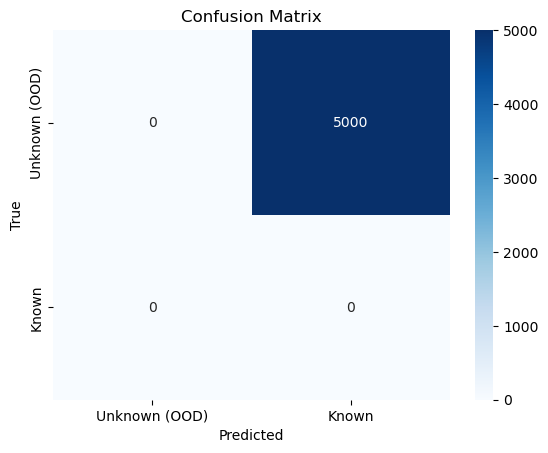

In [122]:
print_cm(artificial_y, predictions_norm)

## Make predictions based off logits

In [123]:
logits = logits_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 1s 30ms/step


In [124]:
from scipy.special import logsumexp

energy = -logsumexp(logits, axis=1)  # Lower = more confident → inlier

threshold = -3.71 # Adjusted to achieve ~95% TPR in in-distribution data
predictions = np.where(energy <= threshold, 1, -1)

Outlier Detection Accuracy: 58.58%
               precision    recall  f1-score   support

Unknown (OOD)       0.75      0.26      0.39      2500
        Known       0.55      0.91      0.69      2500

     accuracy                           0.59      5000
    macro avg       0.65      0.59      0.54      5000
 weighted avg       0.65      0.59      0.54      5000



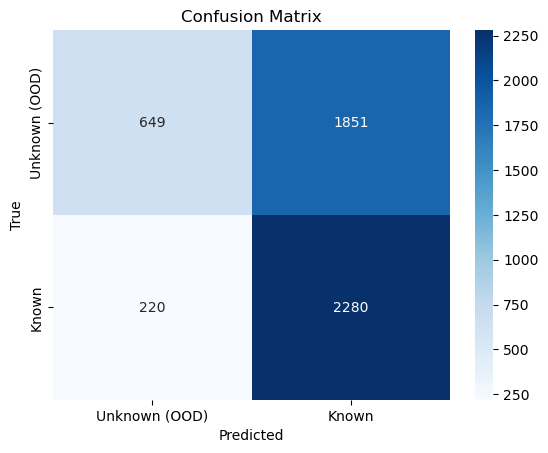

In [125]:
print_evaluation_report(is_known, predictions)

In [129]:
logits_uni = logits_model.predict(uniform_test_flow, verbose=1)
logits_norm = logits_model.predict(normal_test_flow, verbose=1)

20/20 [==============================] - 1s 31ms/step


In [130]:
from scipy.special import logsumexp

energy_uni = -logsumexp(logits_uni, axis=1)  # Lower = more confident → inlier
energy_norm = -logsumexp(logits_norm, axis=1)  # Lower = more confident → inlier

threshold = -3.71
predictions_uni = np.where(energy_uni <= threshold, 1, -1)
predictions_norm = np.where(energy_norm <= threshold, 1, -1)

Outlier Detection Accuracy: 100.00%


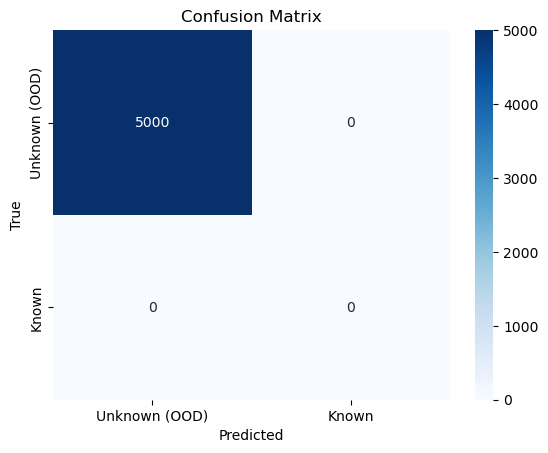

Outlier Detection Accuracy: 100.00%


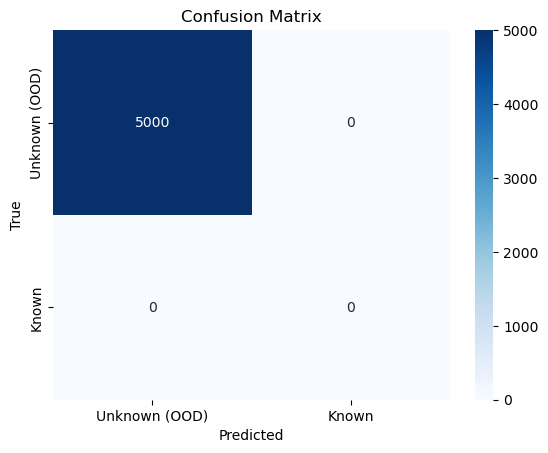

In [131]:
print_cm(artificial_y, predictions_uni)
print_cm(artificial_y, predictions_norm)

## Use ODIN

### Add perturbance to samples

In [132]:
TEMPERATURE = 1000.0
EPSILON = 0.0014

In [133]:
def odin_perturbation(model, x_input, temperature, epsilon):
    x_input = tf.Variable(x_input)

    with tf.GradientTape() as tape:
        tape.watch(x_input)
        logits = model(x_input, training=False)
        logits = logits / temperature
        probs = tf.nn.softmax(logits, axis=1)
        max_probs = tf.reduce_max(probs, axis=1)
        loss = -tf.math.log(max_probs)

    gradients = tape.gradient(loss, x_input)
    signed_grad = tf.sign(gradients)
    perturbed = x_input - epsilon * signed_grad
    perturbed = tf.clip_by_value(perturbed, 0.0, 1.0)
    return perturbed

def odin_batch_scores(model, x_batch, temperature, epsilon):
    perturbed = odin_perturbation(model, x_batch, temperature, epsilon)
    logits = model(perturbed, training=False)
    logits = logits / temperature
    probs = tf.nn.softmax(logits, axis=1).numpy()
    return np.max(probs, axis=1)  # ODIN score per sample

### Apply softmax with temperatures

In [134]:
from tqdm import tqdm

odin_scores = []

for batch_x, _ in tqdm(subset_test_flow, total=len(subset_test_flow)):
    scores = odin_batch_scores(my_model, batch_x, TEMPERATURE, EPSILON)
    odin_scores.extend(scores)

    if len(odin_scores) >= subset_test_flow.n:
        break

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:04<00:00,  4.67it/s]


In [156]:
threshold = 0.111172 # Adjusted to achieve ~95% TPR in in-distribution data
predictions = np.where(np.array(odin_scores) >= threshold, 1, -1)

In [157]:
np.max(np.array(odin_scores)), np.min(np.array(odin_scores))

(0.11120991, 0.11113225)

Outlier Detection Accuracy: 51.58%
               precision    recall  f1-score   support

Unknown (OOD)       0.62      0.08      0.14      2500
        Known       0.51      0.95      0.66      2500

     accuracy                           0.52      5000
    macro avg       0.57      0.52      0.40      5000
 weighted avg       0.57      0.52      0.40      5000



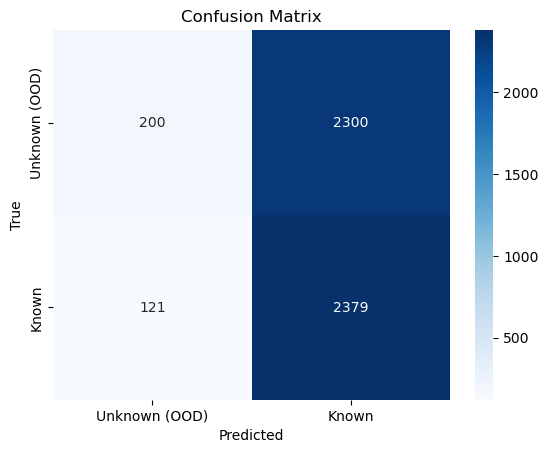

In [158]:
print_evaluation_report(is_known, predictions)

In [159]:
from tqdm import tqdm

odin_scores_norm = []

for batch_x, _ in tqdm(normal_test_flow, total=len(normal_test_flow)):
    scores = odin_batch_scores(my_model, batch_x, TEMPERATURE, EPSILON)
    odin_scores_norm.extend(scores)

    if len(odin_scores_norm) >= normal_test_flow.n:
        break

odin_scores_uni = []

for batch_x, _ in tqdm(uniform_test_flow, total=len(uniform_test_flow)):
    scores = odin_batch_scores(my_model, batch_x, TEMPERATURE, EPSILON)
    odin_scores_uni.extend(scores)

    if len(odin_scores_uni) >= uniform_test_flow.n:
        break

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:03<00:00,  4.79it/s]


In [160]:
predictions_uni = np.where(np.array(odin_scores_uni) >= threshold, 1, -1)
predictions_norm = np.where(np.array(odin_scores_norm) >= threshold, 1, -1)

Outlier Detection Accuracy: 0.00%


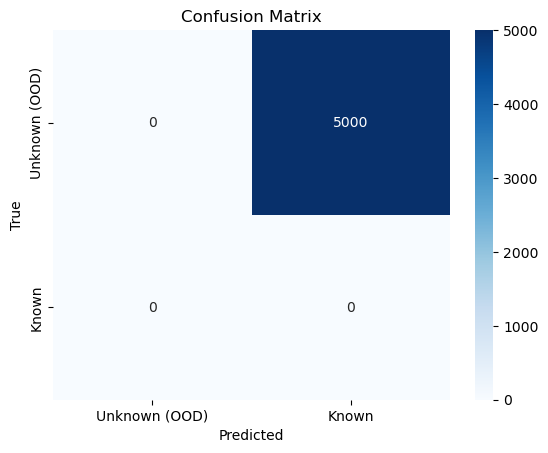

Outlier Detection Accuracy: 0.00%


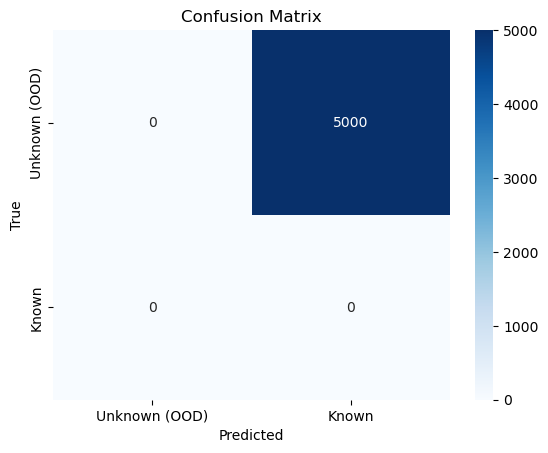

In [161]:
print_cm(artificial_y, predictions_uni)
print_cm(artificial_y, predictions_norm)